In [363]:
%%capture
!pip install numpy scipy pandas matplotlib ipywidgets metex
!jupyter nbextension enable --py widgetsnbextension

In [47]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

import scipy
from scipy.stats import norm
from scipy.special import logsumexp

import metex
from IPython.display import Image

In [37]:
def gain(sk, λ):
    return np.sqrt(np.maximum((-(2+sk)+np.sqrt(sk**2-2*sk/λ))/(2*(1+sk)), 0))

def output_power(sk, λ):
    return gain(sk, λ)**2*(1+sk)+1

def total_output_power(s, λ):
    return output_power(s, λ).sum()

def plot_gain(λ, input_strength):
    fig = plt.figure(constrained_layout=True, figsize=(10, 8))
    gs = fig.add_gridspec(2, 2)
    n_channels = 15
    input_std_min = input_strength*0.5
    input_std_max = input_strength*2
    input_var_min = input_std_min**2
    input_var_max = input_std_max**2
    #input_var_min = 10**input_var_min
    #input_var_max = 10**input_var_max
    if input_var_min > input_var_max:
        (input_var_min, input_var_max) = (input_var_max, input_var_min)
    s = np.linspace(input_var_min,input_var_max,n_channels)
    
    
    a = fig.add_subplot(gs[0,0])
    λ_range = np.linspace(-0.45, -0.05, n_channels)
    a.plot(λ_range, [total_output_power(s, l) for l in λ_range], color='gray')
    a.scatter([λ], [total_output_power(s,λ)], color='red')
    a.axvline(λ, color='red')
    a.axhline(total_output_power(s,λ), color='red')
    a.set_xlabel("λ")
    a.set_ylabel("Total output variance")
    a.set_title("Output variance 'budget'")

    a = fig.add_subplot(gs[0,1])
    for l in λ_range:
        pass
        a.plot(np.sqrt(s), gain(s, l), color='gray', linewidth=0.2)
    a.plot(np.sqrt(s), gain(s, λ), color='red')
    a.set_title("Transfer function")
    a.set_xlabel("Input signal strength for a given channel, $s_k$")
    a.set_ylabel("Channel gain, $|L_k|$")
    
    a = fig.add_subplot(gs[1,:])
    a.bar(np.arange(s.size)+0.2, np.sqrt(s), width=0.4, label='Input signal strength')
    a.bar(np.arange(s.size)-0.2, np.sqrt(output_power(s, λ)), width=0.4, label='Output dynamic range')
    a.axhline(1, label='Noise floor')
    a.legend()
    a.set_xticks([0, 7, 14])
    a.set_xticklabels([1, 8, 15])
    a.set_xlabel('Channel')
    a.set_ylabel('Dynamic range')

In [38]:
interactive(plot_gain,
            λ=widgets.FloatSlider(
                value=-0.25, min=-0.49, max=-.01, step=0.01,
                description='λ (Output variance budget)'), #set width and height),
            input_strength=widgets.FloatLogSlider(
                value=1, min=-2, max=2, step=0.01, base=10,
                description='Signal strength')
           )

interactive(children=(FloatSlider(value=-0.25, description='λ (Output variance budget)', max=-0.01, min=-0.49,…

## Task description
This experiment is designed to test a prediction based on the efficient coding hypothesis at the level of central visual processing. 

<img src='Hermundstad2014_fig_1.png' width="800">

In [39]:
def show_texture(statistic, intensity):
    texture = metex.Texture(height=100, width=100, **{statistic:intensity})
    texture.sample().plot(figsize=(5,5))

In [40]:
interactive(show_texture,
            statistic=widgets.RadioButtons(
                options=[
                    ('γ', 'gamma'),
                    ('β₁', 'beta1'), ('β₂', 'beta2'),
                    ('β₃', 'beta3'), ('β₄', 'beta4'),
                    ('θ₁', 'theta1'), ('θ₂', 'theta2'),
                    ('θ₃', 'theta3'), ('θ₄', 'theta4'),
                    ('α', 'alpha')
                ],
                description='Statistic', value='beta1'),
            intensity=widgets.FloatSlider(
                value=0.7, min=-1, max=1, step=0.01,
                description='Intensity')
           )

interactive(children=(RadioButtons(description='Statistic', index=1, options=(('γ', 'gamma'), ('β₁', 'beta1'),…

## Download and preprocess data

In [2]:
# download data file
! wget https://zenodo.org/record/4763647/files/rat_texture_task.csv

--2022-05-16 21:36:12--  https://zenodo.org/record/4763647/files/rat_texture_task.csv
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33735871 (32M) [text/plain]
Saving to: ‘rat_texture_task.csv’

rat_texture_task.cs 100%[===================>]  32,17M  2,87MB/s    in 13s     

2022-05-16 21:36:26 (2,51 MB/s) - ‘rat_texture_task.csv’ saved [33735871/33735871]



In [199]:
data = pd.read_csv('rat_texture_task.csv')
possible_stimuli = np.array([0, 0.02, 0.09, 0.16, 0.23, 0.30,
                            0.37, 0.44, 0.51, 0.58, 0.65,
                            0.72, 0.79, 0.86, 0.93, 1])
data = data[data.statistic_intensity.isin(possible_stimuli)]
is_texture = data.statistic_intensity!=0
data.loc[:,'report_noise'] = (is_texture ^ data.success)
statistic_names = np.array(['gamma', 'beta', 'theta', 'alpha'])
data['learned_statistic'] = statistic_names[data['learned_statistic'].to_numpy()-1]
data = data\
    .query("experiment_phase == 3")\
    .groupby(["rat_batch", "rat_ID", "learned_statistic", "statistic_intensity"], as_index=False)\
    .aggregate(
    Ts=pd.NamedAgg(column='report_noise', aggfunc='count'),
    Ns=pd.NamedAgg(column='report_noise', aggfunc='sum'))
data

,rat_batch,rat_ID,learned_statistic,statistic_intensity,Ts,Ns
0,1,1,alpha,0.00,8092,6726
1,1,1,alpha,0.02,504,416
2,1,1,alpha,0.09,478,365
3,1,1,alpha,0.16,515,366
4,1,1,alpha,0.23,498,312
...,...,...,...,...,...,...
603,2,6,theta,0.72,394,111
604,2,6,theta,0.79,342,91
605,2,6,theta,0.86,347,75
606,2,6,theta,0.93,338,82


In [200]:
grouped_data = data.groupby(["rat_batch", "rat_ID", "learned_statistic"], as_index=False)

To interpret this data, we are going to simplify a bit the approach taken in Caramellino et al 2021, while keeping its essential components. Some of the text below is adapted from that paper.

## Step 1 - generative model
On any given trial, the nominal (true) value of the statistic is some value $s$. The rats have to report whether the texture is white noise ($s=0$) or not. Note that in the experiment design only the positive axis of the texture space was used, so the two alternatives in practice are $s=0$ and $0<s<1$.

Because the texture has finite size, the empirical value of the statistic in the texture will be somewhat different from $s$. We lump this uncertainty together with that induced by the animal’s perceptual process, and we say that any given trial results on the production of a percept $x$, normally distributed around $s$:
$$
p(x|s) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-s)^2}{2\sigma^2}\right]
$$
Nnote that this means that when $s=1$ the actual percept will be some $x>1$ about half of the time. This doesn't really make sense given how the statistic is defined (because $-1\leq s \leq 1$ by construction), but we will ignore this fact here for the sake of simplicity.

We will assume that each rat has some unknown prior over the alternatives ($s=0$, $s>0$). We will parameterize the prior with the log odds:
$$
\alpha := \ln\frac{p(s=0)}{p(s>0)}
$$
More specifically, we assume that
  each rat assigns a prior probability $p(s=0)=1/(1+e^{-\alpha})$ to
  the presentation of a noise sample, and a probability of
  $1/[K(1+e^{\alpha})]$ to the presentation of a texture coming from
  any of the $K$ nonzero statistic values. Note that this
  choice of prior matches the distribution actually used in generating
  the data for the experiment, except that $\alpha$ is a free
  parameter instead of being fixed at 0.
  
Therefore, **in our model we have two free parameters: $\alpha$ and $\sigma$**, representing respectively the prior bias and the perceptual noise.

## Step 2 - inference
We define a decision variable $D$ as follows:
$$
  D(x) := \ln\frac{p(s=0|x)}{p(s>0|x)} =
  \ln\frac{p(x|s=0)}{p(x|s>0)} + \ln\frac{p(s=0)}{p(s>0)}
$$
With this definition, the rat will report "noise" when $D>0$ and
"texture" otherwise.

By plugging in the likelihood functions and our choice of prior, we
get
$$
    D(x)= \ln\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{x^2}{2\sigma^2}\right] -\ln\left[\frac{1}{K}\sum_k\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-s_k)^2}{2\sigma^2}\right]\right] + \alpha
$$
which we can rewrite
$$
    D(x)= \alpha + \ln K -\frac{x^2}{2\sigma^2} -\ln\left[\sum_k\exp\left[-\frac{(x-s_k)^2}{2\sigma^2}\right]\right]
$$

## Step 3 - response distribution
Now, remember that *given a value of the percept $x$*, the
decision rule based on $D$ is fully deterministic (maximum a
posteriori estimate). But on any given trial we don't know the value
of the percept --- we only know the nominal value of the statistic. On
the other hand, our assumptions above specify the distribution
$p(x|s)$ for any $s$, so the deterministic mapping $D(x)$ means that
we can compute the probability of reporting "noise" as
$$
    p(\text{report noise}|s) = p(D>0|s) = \int_{x:D(x)>0} p(x|s) \mathrm{d}x
$$

Therefore, if we define $x^*$ as the decision criterion in measurement space, i.e.,
$$
x^* = x^*(\alpha,\sigma) \text{ such that } D(x^*)=0
$$
the response distribution is, as usual, a cumulative Gaussian:
$$
p(\text{report noise}|s) = \int_{-\infty}^{x^*}\frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-s)^2}{2\sigma^2}\right]\mathrm{d}x = 1-\Phi\left[{\frac{s-x^{*}}{\sigma}}\right]
$$

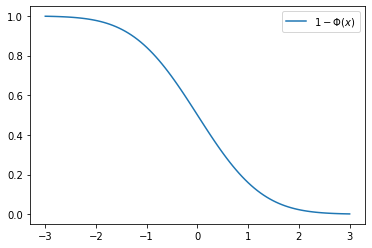

In [223]:
x=np.linspace(-3,3,100); plt.plot(x, 1-norm.cdf(x), label='$1-\Phi(x)$'); plt.legend();

## Step 4 - fitting the model
Independently for each rat, we infer a value of $\alpha$ and $\sigma$
by maximising the likelihood of the data under the model above. More
in detail, for a given rat and a given statistic value $s$ (including
0), we call $N_s$ the number of times the rat reported "noise", and
$T_s$ the total number of trials. For a given fixed value of $\alpha$
and $\sigma$, under the ideal observer model the likelihood of $N_s$
will be given by a Binomial probability distribution for $T_s$ trials
and probability of success given by the probability of reporting noise
computed above
$$
  p_s(N_s|\alpha,\sigma) = \binom{T_s}{N_s}p(\text{rep
    noise}|s,\alpha,\beta)^{N_s}\left(1-p(\text{rep noise}|s,\alpha,\beta)\right)^{T_s-N_s}
$$
Assuming that the data for the different values of $s$ is
conditionally independent given $\alpha$ and $\sigma$, the total log
likelihood for the data of the given rat is simply the sum of the log
likelihoods for the individual values of $N_s$
$$
  LL := \ln p(\{N_{s_k}\}_{k=1}^K|\alpha,\sigma) = \sum_{k=1}^K\ln p_{s_k}(N_k|\alpha,\sigma)
$$
Which we can rewrite
$$
LL = \sum_{s}\left[\ln\binom{T_s}{N_s} + N_s\ln p(\text{rep
    noise}|s,\alpha,\sigma) + (T_s-N_s) \ln\left(1-p(\text{rep
    noise}|s,\alpha,\sigma)\right)\right]\\
    = \sum_{s}\left[N_s\ln p(\text{rep
    noise}|s,\alpha,\sigma) + (T_s-N_s) \ln\left(1-p(\text{rep
    noise}|s,\alpha,\sigma)\right)\right] + C
$$
where $C$ is a constant that does not depend on $\alpha$ and $\sigma$.

### Step 4.1 - defining the objective function to be minimized by the fit
Below we implement the calculation of $LL$ given $\alpha$, $\sigma$ and the data. Note that computing this function can be done numerically on a computer, but it wouldn't be possible to do it by hand in closed form because computing $LL$ requires computing $p(\text{rep noise}|s, \alpha,\sigma)$, which in turn requires computing $x^*$ (see definitions above).

In [208]:
def D(x, α, σ):
    possible_stimuli = np.arange(0.02, 1.01, 0.07)
    K = possible_stimuli.size
    return α + np.log(K) - x**2/(2*σ**2) - logsumexp(-(x-possible_stimuli)**2/(2*σ)**2)

def x_star(α, σ):
    return scipy.optimize.root_scalar(D, args=(α, σ), x0=0, x1=1).root# bracket=[-0.1,1]).root

def p_rep_noise(s, α, σ):
    return 1-norm.cdf((s - x_star(α, σ))/σ)

In [350]:
def plot_response_distribution(α, σ):
    s_range = np.linspace(0, 1, 50)
    fig, ax = plt.subplots()
    ax.plot(s_range, p_rep_noise(s_range, α, σ));
    ax.set_xlabel('True intensity of the statistic')
    ax.set_ylabel("Probability of reporting 'noise'")
    ax.set_ylim(0,1)
    return fig, ax

In [364]:
interactive(plot_response_distribution,
            α=widgets.FloatSlider(
                value=0, min=-1, max=1, step=0.01,
                description='α'),
            σ=widgets.FloatSlider(
                value=0.2, min=0.05, max=1, step=0.01,
                description='σ'),
           )

interactive(children=(FloatSlider(value=0.0, description='α', max=1.0, min=-1.0, step=0.01), FloatSlider(value…

In [251]:
def LL(α, σ, Ts, Ns):
    ps = p_rep_noise(possible_stimuli, α, σ)
    return np.sum(Ns * np.log(ps) + \
                 (Ts-Ns) * np.log(1-ps))

def objective_function(params, Ts, Ns):
    α, σ = params
    return -LL(α, σ, Ts, Ns)

### Step 4.2 - actually perform the fit

In [316]:
def fit_model(single_rat_data):
    Ts = single_rat_data.Ts
    Ns = single_rat_data.Ns
    sol = scipy.optimize.minimize(
        objective_function,
        x0=np.array((0.1, 0.4)),
        args=(Ts, Ns),
        method='Nelder-Mead')
    return sol.x

In [326]:
fitted_params = {
    'rat_batch' : [],
    'rat_ID' : [],
    'statistic': [],
    'α' : [],
    'σ' : []
}

for rat, this_rat_data in grouped_data:
    (α, σ) = fit_model(this_rat_data)
    fitted_params['rat_batch'].append(rat[0])
    fitted_params['rat_ID'].append(rat[1])
    fitted_params['statistic'].append(rat[2])
    fitted_params['α'].append(α)
    fitted_params['σ'].append(σ)

fitted_params = pd.DataFrame(fitted_params)

/tmp/ipykernel_26206/4060472500.py:4: RuntimeWarning: divide by zero encountered in log
  (Ts-Ns) * np.log(1-ps))
/tmp/ipykernel_26206/4060472500.py:3: RuntimeWarning: divide by zero encountered in log
  return np.sum(Ns * np.log(ps) + \


## Visualize fit results

In [349]:
def plot_rat_fit(rat_abs_number):
    (rat_batch, rat_ID, statistic, α, σ) = fitted_params.loc[rat_abs_number].to_numpy()
    rat_data = data.query(f"rat_batch=={rat_batch} & rat_ID=={rat_ID} & learned_statistic=='{statistic}'")
    fig, ax = plot_response_distribution(α, σ)
    ax.scatter(rat_data.statistic_intensity, rat_data.Ns/rat_data.Ts)
    ax.text(0.98, 0.95,
            f"Batch: {rat_batch}, rat: {rat_ID}, statistic: {statistic}\nα={α:.2f}, σ={σ:.2f}",
            horizontalalignment='right', verticalalignment='top'
           )
    
interactive(plot_rat_fit,
            rat_abs_number=widgets.IntSlider(
                value=0, min=0, max=len(fitted_params)-1, description='Rat ID'))

interactive(children=(IntSlider(value=0, description='Rat ID', max=37), Output()), _dom_classes=('widget-inter…

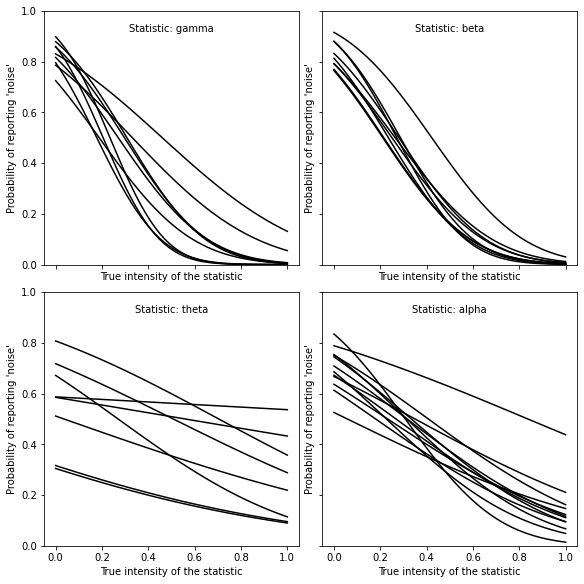

In [360]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True, constrained_layout=True)
for k, statistic in enumerate(['gamma', 'beta', 'theta', 'alpha']):
    a = ax.flat[k]
    s_range = np.linspace(0, 1, 50)
    this_stat_rats = fitted_params.query(f"statistic=='{statistic}'")
    for (rat_batch, rat_ID, statistic, α, σ) in this_stat_rats.to_numpy():
        a.plot(s_range, p_rep_noise(s_range, α, σ), color='k')
    a.set_xlabel('True intensity of the statistic')
    a.set_ylabel("Probability of reporting 'noise'")
    a.set_ylim(0,1)
    a.text(0.5, 0.95, f"Statistic: {statistic}",
            horizontalalignment='center', verticalalignment='top')

<img src='Hermundstad2014_fig_1_extract.png' width="600">

Text(0, 0.5, 'Sensitivity')

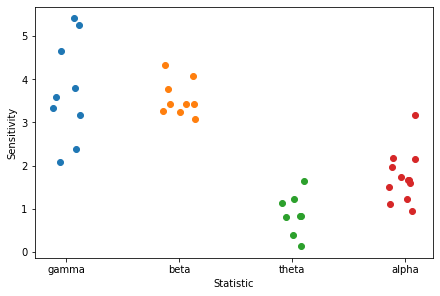

In [371]:
fig, ax = plt.subplots(constrained_layout=True)
sensitivities = {}
for k, statistic in enumerate(['gamma', 'beta', 'theta', 'alpha']):
    this_stat_rats = fitted_params.query(f"statistic=='{statistic}'")
    sensitivities[statistic] = 1/this_stat_rats.σ.to_numpy()
    ax.scatter([k]+(np.random.rand(len(this_stat_rats))-0.5)*0.3,
               sensitivities[statistic])
ax.set_xlabel('Statistic')
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(['gamma', 'beta', 'theta', 'alpha'])
ax.set_ylabel('Sensitivity')

## Compare model fits with predictions of the theory

<img src='Hermundstad2014_fig_3A.png' width="600">

In [377]:
# human sensitivity to correlated patterns from Hermundstad et al 2014.
# Respectively beta (2-point), theta (3-point), and alpha (4-point)
human = np.array([0.88489849, 0.29890596, 0.35722528])

# variablity of 2-point, 3-point and 4-point statistics in natural images
images = np.array([3.79, 1.13, 1.44])

# compute average sensitivities for rats
rat = np.array([values.mean() for values in sensitivities.values()])
# discard sensitivity to gamma as that was not examined in humans
rat = rat[1:]

# normalize all three sets of empirical data to put them all on the same scale
human /= np.linalg.norm(human)
images /= np.linalg.norm(images)
rat /= np.linalg.norm(rat)

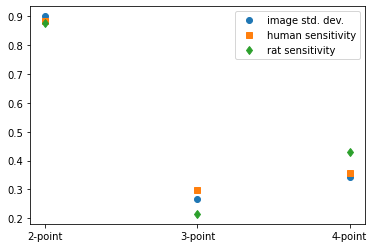

In [379]:
fig, ax = plt.subplots()
ax.plot(images, 'o', label='image std. dev.')
ax.plot(human, 's', label='human sensitivity')
ax.plot(rat, 'd', label='rat sensitivity')
ax.legend()
ax.set_xticks([0,1,2])
ax.set_xticklabels(['2-point', '3-point', '4-point']);